In [ ]:
'''
CIND820 Project - Sentiment and Classification Analysis on Yelp Dataset 
Time: Jan - Apr 2021
YINGQI HU

Note: 
This analysis replicates: Siqi Liu. "Sentiment Analysis of Yelp Reviews:A Comparison of Techniques and Models"(2020)

On top of replication, following changes will be implemented:
1)In terms of the polarity categories for sentiment analysis, instead of assign only 3 categories (negative, neutral, positive),
  fine-grained sentiment analysis will be used to interpret 5-star review ratings (very negative, negative, neutral, positive, very positive).
2)Time Series cross-validattion is used instead of train_test_split. The date of each review will be considered while spliting training and testing dataset. 
  Reviews from earlier time will be assigned to training set and reviews from later time will be assigned to testing set.
3)Besides analysis on text reviews, classification analysis on business attributes for predicting rating will be added 
'''

In [5]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import tarfile
from tqdm import tqdm, tqdm_notebook, tnrange
import json
import csv
import numpy as np
import time
from copy import deepcopy
import warnings
import gc

In [2]:
!pip install matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

In [3]:
!pip install seaborn
import seaborn as sns

In [4]:
# Handle date time conversions between pandas and matplotlib
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Use white grid plot background from seaborn
sns.set(font_scale=1.5, style="whitegrid")

In [5]:
import os
cwd = os.getcwd()
print (cwd)

C:\Users\Saivi\AppData\Local\Programs\Python\Python39\Scripts\Yelp Project


In [11]:
#pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [6]:
zf = tarfile.open('yelp_dataset.tar','r') 
zf.getmembers()

[<TarInfo '.' at 0x1cb638e14c0>,
 <TarInfo './yelp_academic_dataset_user.json' at 0x1cb638e1040>,
 <TarInfo './yelp_academic_dataset_tip.json' at 0x1cb638e1340>,
 <TarInfo './yelp_academic_dataset_checkin.json' at 0x1cb638e1580>,
 <TarInfo './Dataset_User_Agreement.pdf' at 0x1cb638e1640>,
 <TarInfo './yelp_academic_dataset_business.json' at 0x1cb638e1700>,
 <TarInfo './yelp_academic_dataset_review.json' at 0x1cb638e17c0>]

In [16]:
zf.extract('./yelp_academic_dataset_business.json')

In [17]:
zf.extract('./yelp_academic_dataset_review.json')

In [7]:
#Change setting to display all columns and full string
pd.set_option('display.max_columns',600)
pd.set_option('display.max_colwidth',100)

# Review

In [10]:
#Step1:review data: './yelp_academic_dataset_review.json'

In [8]:
review_data = []
with open('./yelp_academic_dataset_review.json',encoding="utf8") as f:
    for line in f:
        review_data.append(json.loads(line))
review_df = pd.DataFrame.from_dict(review_data)
# Make sure specify : encoding="utf8" to avoid decoding errors

In [10]:
print(review_df.head(1))

                review_id                 user_id             business_id  \
0  xQY8N_XvtGbearJ5X4QryQ  OwjRMXRC0KyPrIlcjaXeFQ  -MhfebM0QIsKt87iDN-FNw   

   stars  useful  funny  cool  \
0    2.0       5      0     0   

                                                                                                  text  \
0  As someone who has worked with many museums, I was eager to visit this gallery on my most recent...   

                  date  
0  2015-04-15 05:21:16  


In [11]:
print(review_df.columns)
print(review_df.shape)
print(review_df.info())

Index(['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny',
       'cool', 'text', 'date'],
      dtype='object')
(8021122, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8021122 entries, 0 to 8021121
Data columns (total 9 columns):
 #   Column       Dtype  
---  ------       -----  
 0   review_id    object 
 1   user_id      object 
 2   business_id  object 
 3   stars        float64
 4   useful       int64  
 5   funny        int64  
 6   cool         int64  
 7   text         object 
 8   date         object 
dtypes: float64(1), int64(3), object(5)
memory usage: 550.8+ MB
None


In [12]:
#Are all business id unique?
print(review_df.business_id.is_unique) 
print(review_df.review_id.is_unique) 

False
True


In [15]:
#Save dataframe as csv file
review_df.to_csv("review_df.csv")

In [16]:
#Dealing with 'date' data to check the timeframe of the review dataset
review_timeframe = pd.read_csv('review_df.csv',parse_dates=['date'], index_col=['date'])

In [ ]:
print(review_timeframe.columns)
print(review_timeframe.shape)
print(review_timeframe.info())

In [89]:
review_timeframe.head(1)

,Unnamed: 0,review_id,user_id,business_id,stars,useful,funny,cool,text
date,,,,,,,,,
2015-04-15 05:21:16,0,xQY8N_XvtGbearJ5X4QryQ,OwjRMXRC0KyPrIlcjaXeFQ,-MhfebM0QIsKt87iDN-FNw,2.0,5,0,0,"As someone who has worked with many museums, I was eager to visit this gallery on my most recent trip to Las Vegas. When I saw they would be showing infamous eggs of the House of Faberge from the Virginia Museum of Fine Arts (VMFA), I knew I had to go!\n\nTucked away near the gelateria and the garden, the Gallery is pretty much hidden from view. It's what real estate agents would call ""cozy"" or ""charming"" - basically any euphemism for small.\n\nThat being said, you can still see wonderful art at a gallery of any size, so why the two *s you ask? Let me tell you:\n\n* pricing for this, while relatively inexpensive for a Las Vegas attraction, is completely over the top. For the space and the amount of art you can fit in there, it is a bit much.\n* it's not kid friendly at all. Seriously, don't bring them.\n* the security is not trained properly for the show. When the curating and design teams collaborate for exhibitions, there is a definite flow. That means visitors should view the art in a certain sequence, whether it be by historical period or cultural significance (this is how audio guides are usually developed). When I arrived in the gallery I could not tell where to start, and security was certainly not helpful. I was told to ""just look around"" and ""do whatever."" \n\nAt such a *fine* institution, I find the lack of knowledge and respect for the art appalling."


In [17]:
# Check min value of index 
print(review_timeframe.index.min())

2004-10-12 10:13:32


In [91]:
# Check max value of index 
print(review_timeframe.index.max())

2019-12-13 15:51:19


In [92]:
#Distribution of reviews from star 1 to star 5:

star1_reviews = len(review_timeframe[review_timeframe["stars"]==1])
star2_reviews = len(review_timeframe[review_timeframe["stars"]==2])
star3_reviews = len(review_timeframe[review_timeframe["stars"]==3])
star4_reviews = len(review_timeframe[review_timeframe["stars"]==4])
star5_reviews = len(review_timeframe[review_timeframe["stars"]==5])
total_reviews = len(review_timeframe)
star1_percentage = star1_reviews/total_reviews
star2_percentage = star2_reviews/total_reviews
star3_percentage = star3_reviews/total_reviews
star4_percentage = star4_reviews/total_reviews
star5_percentage = star5_reviews/total_reviews

print("Total star1 reviews: {}, percentage:{:.0%}".format(star1_reviews,star1_percentage))
print("Total star2 reviews: {}, percentage:{:.0%}".format(star2_reviews,star2_percentage))
print("Total star3 reviews: {}, percentage:{:.0%}".format(star3_reviews,star3_percentage))
print("Total star4 reviews: {}, percentage:{:.0%}".format(star4_reviews,star4_percentage))
print("Total star5 reviews: {}, percentage:{:.0%}".format(star5_reviews,star5_percentage))
print("Total reviews: {}".format(total_reviews))

Total star1 reviews: 1283897, percentage:16%
Total star2 reviews: 635072, percentage:8%
Total star3 reviews: 842289, percentage:11%
Total star4 reviews: 1673404, percentage:21%
Total star5 reviews: 3586460, percentage:45%
Total reviews: 8021122


<AxesSubplot:xlabel='stars', ylabel='Count'>

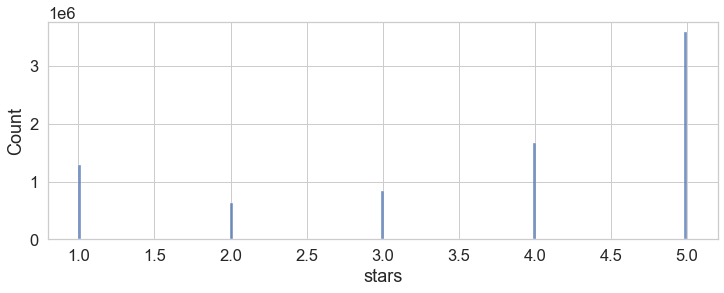

In [95]:
#Visualize distribution of review ratings:
sns.histplot(review_timeframe.stars)

In [11]:
print(review_df.isnull().sum().sort_values(ascending=False))

review_id      0
user_id        0
business_id    0
stars          0
useful         0
funny          0
cool           0
text           0
date           0
dtype: int64


In [9]:
review_final = review_df[['review_id', 'business_id', 'stars', 'text','date']]
review_final = review_final.rename(columns={'stars':'review_stars', 'text':'review_text'})

In [13]:
review_final.head(1)

,review_id,business_id,review_stars,review_text,date
0,xQY8N_XvtGbearJ5X4QryQ,-MhfebM0QIsKt87iDN-FNw,2.0,"As someone who has worked with many museums, I was eager to visit this gallery on my most recent...",2015-04-15 05:21:16


# Business

In [ ]:
#Step 2: business data : './yelp_academic_dataset_business.json'

In [10]:
business_data = []
with open('./yelp_academic_dataset_business.json',encoding="utf8") as f:
    for line in f:
        business_data.append(json.loads(line))
business_df = pd.DataFrame.from_dict(business_data)

In [15]:
len(business_df)

209393

In [16]:
#Overview of the datastruction on business_df
print(business_df.columns)
print(business_df.shape)

Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars', 'review_count', 'is_open',
       'attributes', 'categories', 'hours'],
      dtype='object')
(209393, 14)


In [17]:
#Check Null values:
print(business_df.isnull().sum().sort_values(ascending=False))

hours           44843
attributes      29045
categories        524
business_id         0
name                0
address             0
city                0
state               0
postal_code         0
latitude            0
longitude           0
stars               0
review_count        0
is_open             0
dtype: int64


In [24]:
#Are all business ids unique?
print(business_df.business_id.is_unique) 
#business id is unique

True


In [25]:
print(business_df.city.value_counts())
#Total 1251 cities, top three cities: Las Vegas, Toronto, Phoenix

Las Vegas              31631
Toronto                20366
Phoenix                20171
Charlotte              10422
Scottsdale              9342
                       ...  
Norval                     1
Le Sud-Ouest               1
Leeds                      1
Nottingham Township        1
Scarobrough                1
Name: city, Length: 1251, dtype: int64


In [26]:
#Visualize Number of business listed in different cities
city_business_counts = business_df[['city', 'business_id']].groupby(['city'])['business_id'].agg('count').sort_values(ascending=False)
city_business_counts = pd.DataFrame(data=city_business_counts)
city_business_counts.rename(columns={'business_id' : 'number_of_businesses'}, inplace=True)

Text(0.5, 1.0, 'Top 50 cities by businesses listed')

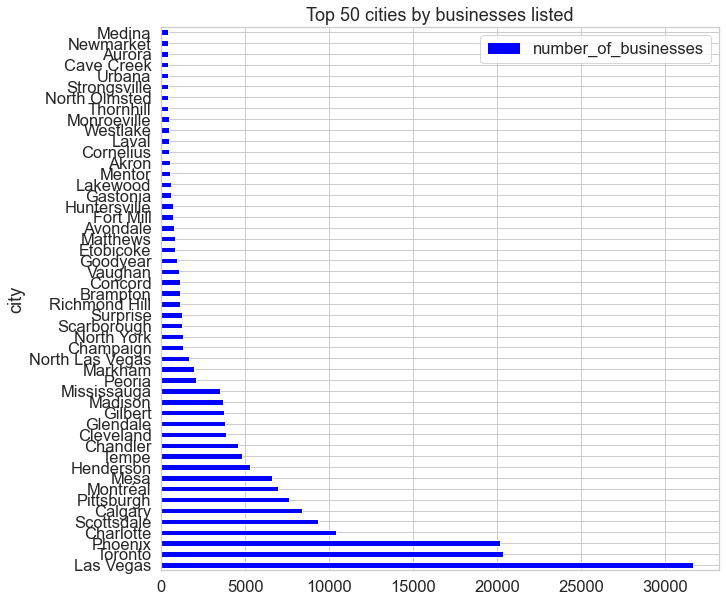

In [27]:
city_business_counts[0:50].sort_values(ascending=False, by="number_of_businesses")\
.plot(kind='barh', stacked=False, figsize=[10,10], colormap='winter')
plt.title('Top 50 cities by businesses listed')

In [28]:
#Distribution of stars
print(business_df['stars'].value_counts())

4.0    39199
3.5    38079
4.5    29940
3.0    28634
5.0    27080
2.5    21435
2.0    13124
1.5     6004
1.0     5898
Name: stars, dtype: int64


<AxesSubplot:xlabel='stars', ylabel='Count'>

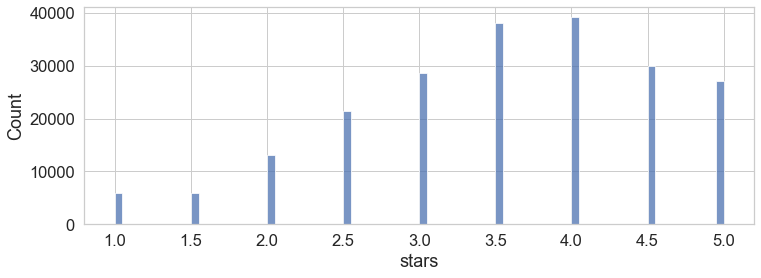

In [29]:
sns.histplot(business_df.stars)

In [11]:
#Remove rows that have null values in categories
business_df = business_df[business_df['categories'].notna()]

In [19]:
business_df.head(1).attributes

0    {'BusinessAcceptsCreditCards': 'True', 'BikeParking': 'True', 'GoodForKids': 'False', 'BusinessP...
Name: attributes, dtype: object

In [32]:
#How many business categories in total?
business_cats=','.join(business_df['categories'])
cats=pd.DataFrame(business_cats.split(','),columns=['category'])
x=cats.category.value_counts()
print("There are ",len(x)," different types/categories of Businesses in Yelp!")

There are  2528  different types/categories of Businesses in Yelp!


In [28]:
#For the purpose of this analysis, we will focus only on "Restaurant"
#Below is the steps taken to filter data with 'categories' cantains 'Restarurnt'
#Note:below coding can also be used to filer data based on other attributes, e.g. city

In [12]:
#First create a filtering list
restaurant_cat = []
for c in business_df['categories']:
    if 'Restaurant'in str(c):
        restaurant_cat.append(c)
print(restaurant_cat[:5])

['Ethnic Food, Food Trucks, Specialty Food, Imported Food, Argentine, Food, Restaurants, Empanadas', 'Food, Restaurants, Grocery, Middle Eastern', 'Restaurants, Cheesesteaks, Poutineries', 'Japanese, Fast Food, Food Court, Restaurants', 'Persian/Iranian, Turkish, Middle Eastern, Restaurants, Kebab']


In [14]:
#Filter data with the list created
restaurant_df = business_df.loc[business_df['categories'].isin(restaurant_cat)]
print(len(restaurant_df))

63961


In [22]:
print(restaurant_df.business_id.is_unique) 

True


In [23]:
restaurant_df['city'].value_counts(dropna=False)

Toronto           8681
Las Vegas         6937
Phoenix           4221
Montréal          4097
Calgary           3117
                  ... 
Sunrise Manor        1
Schottsdale          1
Troy Township        1
Garfield Hts.        1
Sainte-thérèse       1
Name: city, Length: 813, dtype: int64

In [15]:
# Toronto restaurant only
restaurant_TO = restaurant_df.loc[restaurant_df['city'] == 'Toronto']

In [25]:
len(restaurant_TO)

8681

In [39]:
restaurant_TO.head(1)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
38,rVBPQdeayMYht4Uv_FOLHg,Gourmet Burger Company,843 Kipling Avenue,Toronto,ON,M8Z 5G9,43.633291,-79.531768,3.0,13,0,"{'RestaurantsPriceRange2': '2', 'RestaurantsAttire': 'u'casual'', 'Alcohol': 'u'none'', 'Caters'...","Restaurants, Burgers, Food",None


In [40]:
restaurant_TO['review_count'].value_counts()

3      688
4      472
5      399
6      337
7      296
      ... 
501      1
573      1
613      1
781      1
751      1
Name: review_count, Length: 421, dtype: int64

<AxesSubplot:xlabel='review_count', ylabel='Count'>

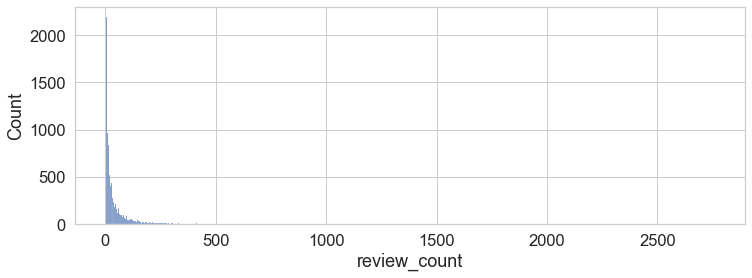

In [41]:
sns.histplot(restaurant_TO['review_count'])

In [16]:
restaurant_TO_10plus = restaurant_TO.loc[restaurant_TO['review_count'] >= 10]

In [27]:
len(restaurant_TO_10plus)

5979

In [28]:
restaurant_TO_10plus.head(1)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
38,rVBPQdeayMYht4Uv_FOLHg,Gourmet Burger Company,843 Kipling Avenue,Toronto,ON,M8Z 5G9,43.633291,-79.531768,3.0,13,0,"{'RestaurantsPriceRange2': '2', 'RestaurantsAttire': 'u'casual'', 'Alcohol': 'u'none'', 'Caters'...","Restaurants, Burgers, Food",None


In [18]:
restaurant_final = restaurant_TO_10plus[['business_id', 'name', 'city','state','stars','review_count','is_open','attributes','categories']]
restaurant_final = restaurant_final.reset_index(drop=True)
restaurant_final = restaurant_final.rename(columns={'name':'business_name','stars':'business_stars'})

In [30]:
restaurant_final.head(1)

,business_id,business_name,city,state,business_stars,review_count,is_open,attributes,categories
0,rVBPQdeayMYht4Uv_FOLHg,Gourmet Burger Company,Toronto,ON,3.0,13,0,"{'RestaurantsPriceRange2': '2', 'RestaurantsAttire': 'u'casual'', 'Alcohol': 'u'none'', 'Caters'...","Restaurants, Burgers, Food"


In [47]:
restaurant_final['business_name'].value_counts()

McDonald's                         38
Aroma Espresso Bar                 20
Pizzaiolo                          20
Swiss Chalet Rotisserie & Grill    20
Freshii                            20
                                   ..
Buca Yorkville                      1
Randy's Roti & Doubles              1
The Victorian Monkey                1
Darbar Persian Grill                1
0109 Dessert & Chocolate            1
Name: business_name, Length: 5127, dtype: int64

In [48]:
restaurant_final.isnull().sum()

business_id        0
business_name      0
city               0
state              0
business_stars     0
review_count       0
is_open            0
attributes        14
categories         0
dtype: int64

In [19]:
#Remove data which 'attributes' is null
restaurant_final = restaurant_final[restaurant_final['attributes'].notna()]

In [32]:
restaurant_final.isnull().sum()

business_id       0
business_name     0
city              0
state             0
business_stars    0
review_count      0
is_open           0
attributes        0
categories        0
dtype: int64

In [33]:
len(restaurant_final)

5965

In [20]:
!pip install flat-table

In [21]:
import flat_table

In [22]:
#'attributes' column includes nested-dictionary. Use flat table to flatten nested dictionary
df_flatten = flat_table.normalize(restaurant_final,expand_dicts=True, expand_lists=False)

In [37]:
df_flatten.head(1)

,index,business_id,business_name,city,state,business_stars,review_count,is_open,categories,attributes.RestaurantsCounterService,attributes.BusinessAcceptsBitcoin,attributes.AcceptsInsurance,attributes.AgesAllowed,attributes.DietaryRestrictions,attributes.ByAppointmentOnly,attributes.Corkage,attributes.BYOB,attributes.BusinessAcceptsCreditCards,attributes.Smoking,attributes.CoatCheck,attributes.GoodForDancing,attributes.BestNights,attributes.HappyHour,attributes.Music,attributes.WheelchairAccessible,attributes.DogsAllowed,attributes.DriveThru,attributes.RestaurantsTableService,attributes.BikeParking,attributes.GoodForMeal,attributes.OutdoorSeating,attributes.Ambience,attributes.WiFi,attributes.NoiseLevel,attributes.BusinessParking,attributes.RestaurantsReservations,attributes.RestaurantsDelivery,attributes.RestaurantsTakeOut,attributes.RestaurantsGoodForGroups,attributes.GoodForKids,attributes.HasTV,attributes.Caters,attributes.Alcohol,attributes.RestaurantsAttire,attributes.RestaurantsPriceRange2
0,0,rVBPQdeayMYht4Uv_FOLHg,Gourmet Burger Company,Toronto,ON,3.0,13,0,"Restaurants, Burgers, Food",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,"{'romantic': False, 'intimate': False, 'classy': False, 'hipster': False, 'divey': False, 'touri...",'no',u'average',"{'garage': False, 'street': False, 'validated': False, 'lot': True, 'valet': False}",False,False,True,True,True,False,False,u'none',u'casual',2


In [38]:
#Notice that only first level of the nested dictionary is flattened. Some attributes like 'BusinessParking' still has dictionary in the column
#The cause of this: the whole second-level dictionary is a string and the value of the dictionary does not has "''" and so not treated as string
#Following code is a testing code to add "''" to the value of the dictionary 
json.loads(df_flatten.head(1)['attributes.Ambience'][0].replace("\'", "\"").replace(": ",":\"").replace(",","\",").replace("}","\"}"))

{'romantic': 'False',
 'intimate': 'False',
 'classy': 'False',
 'hipster': 'False',
 'divey': 'False',
 'touristy': 'False',
 'trendy': 'False',
 'upscale': 'False',
 'casual': 'True'}

In [23]:
#Below code is to convert value of the sub-dictionary to datatype ‘str'
# data fix for 'BusinessParking'
import re
# iterate each row in restaurant_final to fix 'BusinessParking' data
for index,row in restaurant_final.iterrows():
    # if BusinessParking has a nested sub-dict
    #     convert it to json and replace the original
    if(row.attributes is not None and isinstance(row.attributes, dict) and 'BusinessParking' in row.attributes.keys() and isinstance(row.attributes['BusinessParking'], str) and row.attributes['BusinessParking']!='None'):
        bp_str = re.sub(":\s(\w+)",":'\\1'",row.attributes['BusinessParking']).replace("'","\"")
        row.attributes['BusinessParking'] = json.loads(bp_str)
#restaurant_final.head(2)

In [24]:
# data fix for 'GoodForMeal'
for index,row in restaurant_final.iterrows():
    # if GoodForMeal has a nested sub-dict
    #     convert it to json and replace the original
    if(row.attributes is not None and isinstance(row.attributes, dict) and 'GoodForMeal' in row.attributes.keys() and isinstance(row.attributes['GoodForMeal'], str) and row.attributes['GoodForMeal']!='None'):
        bp_str = re.sub(":\s(\w+)",":'\\1'",row.attributes['GoodForMeal']).replace("'","\"")
        row.attributes['GoodForMeal'] = json.loads(bp_str)
#restaurant_final.head(2)

In [25]:
# data fix for 'Ambience'
for index,row in restaurant_final.iterrows():
    # if Ambience has a nested sub-dict
    #     convert it to json and replace the original
    if(row.attributes is not None and isinstance(row.attributes, dict) and 'Ambience' in row.attributes.keys() and isinstance(row.attributes['Ambience'], str) and row.attributes['Ambience']!='None'):
        bp_str = re.sub(":\s(\w+)",":'\\1'",row.attributes['Ambience']).replace("'","\"")
        row.attributes['Ambience'] = json.loads(bp_str)
#restaurant_final.head(2)

In [26]:
# data fix for 'BestNights'
for index,row in restaurant_final.iterrows():
    # if BestNights has a nested sub-dict
    #     convert it to json and replace the original
    if(row.attributes is not None and isinstance(row.attributes, dict) and 'BestNights' in row.attributes.keys() and isinstance(row.attributes['BestNights'], str) and row.attributes['BestNights']!='None'):
        bp_str = re.sub(":\s(\w+)",":'\\1'",row.attributes['BestNights']).replace("'","\"")
        row.attributes['BestNights'] = json.loads(bp_str)

In [27]:
# data fix for 'Music'
for index,row in restaurant_final.iterrows():
    # if Music has a nested sub-dict
    #     convert it to json and replace the original
    if(row.attributes is not None and isinstance(row.attributes, dict) and 'Music' in row.attributes.keys() and isinstance(row.attributes['Music'], str) and row.attributes['Music']!='None'):
        bp_str = re.sub(":\s(\w+)",":'\\1'",row.attributes['Music']).replace("'","\"")
        row.attributes['Music'] = json.loads(bp_str)

In [28]:
# data fix for 'DietaryRestrictions'
for index,row in restaurant_final.iterrows():
    # if DietaryRestrictions has a nested sub-dict
    #     convert it to json and replace the original
    if(row.attributes is not None and isinstance(row.attributes, dict) and 'DietaryRestrictions' in row.attributes.keys() and isinstance(row.attributes['DietaryRestrictions'], str) and row.attributes['DietaryRestrictions']!='None'):
        bp_str = re.sub(":\s(\w+)",":'\\1'",row.attributes['DietaryRestrictions']).replace("'","\"")
        row.attributes['DietaryRestrictions'] = json.loads(bp_str)

In [29]:
#To check whether any column has nested-dictionary:
errlist = []
for index,row in restaurant_final.iterrows():
    if(row.attributes is not None):
        for k in row.attributes.keys():
            if(isinstance(row.attributes[k], str) and "{" in row.attributes[k]):
                if k not in errlist:
                    errlist.append(k)
                    print(k)
                #print(str(index) +" - "+ k+": "+row.attributes[k])
print(errlist)

[]


In [30]:
#Now run below code to flatten the sub-dictionaries
restaurant_final = flat_table.normalize(restaurant_final,expand_dicts=True, expand_lists=True)

In [65]:
restaurant_final.to_csv("restaurant_final.csv")

In [47]:
restaurant_final.head(1)

,index,business_id,business_name,city,state,business_stars,review_count,is_open,categories,attributes.RestaurantsCounterService,attributes.BusinessAcceptsBitcoin,attributes.AcceptsInsurance,attributes.Music,attributes.AgesAllowed,attributes.GoodForMeal,attributes.DietaryRestrictions.vegetarian,attributes.DietaryRestrictions.soy-free,attributes.DietaryRestrictions.halal,attributes.DietaryRestrictions.kosher,attributes.DietaryRestrictions.vegan,attributes.DietaryRestrictions.gluten-free,attributes.DietaryRestrictions.dairy-free,attributes.Ambience,attributes.ByAppointmentOnly,attributes.Corkage,attributes.BYOB,attributes.BusinessAcceptsCreditCards,attributes.Smoking,attributes.CoatCheck,attributes.BusinessParking,attributes.BestNights.saturday,attributes.BestNights.sunday,attributes.BestNights.thursday,attributes.BestNights.wednesday,attributes.BestNights.friday,attributes.BestNights.tuesday,attributes.BestNights.monday,attributes.Music.karaoke,attributes.Music.video,attributes.Music.live,attributes.Music.jukebox,attributes.Music.no_music,attributes.Music.background_music,attributes.Music.dj,attributes.GoodForDancing,attributes.HappyHour,attributes.WheelchairAccessible,attributes.DogsAllowed,attributes.DriveThru,attributes.GoodForMeal.breakfast,attributes.GoodForMeal.brunch,attributes.GoodForMeal.dinner,attributes.GoodForMeal.lunch,attributes.GoodForMeal.latenight,attributes.GoodForMeal.dessert,attributes.RestaurantsTableService,attributes.BikeParking,attributes.Ambience.casual,attributes.Ambience.upscale,attributes.Ambience.trendy,attributes.Ambience.touristy,attributes.Ambience.divey,attributes.Ambience.hipster,attributes.Ambience.classy,attributes.Ambience.intimate,attributes.Ambience.romantic,attributes.BusinessParking.valet,attributes.BusinessParking.lot,attributes.BusinessParking.validated,attributes.BusinessParking.street,attributes.BusinessParking.garage,attributes.OutdoorSeating,attributes.WiFi,attributes.NoiseLevel,attributes.RestaurantsReservations,attributes.RestaurantsDelivery,attributes.RestaurantsTakeOut,attributes.RestaurantsGoodForGroups,attributes.GoodForKids,attributes.HasTV,attributes.Caters,attributes.Alcohol,attributes.RestaurantsAttire,attributes.RestaurantsPriceRange2
0,0,rVBPQdeayMYht4Uv_FOLHg,Gourmet Burger Company,Toronto,ON,3.0,13,0,"Restaurants, Burgers, Food",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,'no',u'average',False,False,True,True,True,False,False,u'none',u'casual',2


# Merge

In [31]:
#Merge restaurant_final and review_final to one dataset
#Merge on 'business_id'
dataset = restaurant_final.merge(review_final, how='left', on='business_id', sort=True)

In [49]:
#One review record for each business is one row
dataset.head(2)

,index,business_id,business_name,city,state,business_stars,review_count,is_open,categories,attributes.RestaurantsCounterService,attributes.BusinessAcceptsBitcoin,attributes.AcceptsInsurance,attributes.Music,attributes.AgesAllowed,attributes.GoodForMeal,attributes.DietaryRestrictions.vegetarian,attributes.DietaryRestrictions.soy-free,attributes.DietaryRestrictions.halal,attributes.DietaryRestrictions.kosher,attributes.DietaryRestrictions.vegan,attributes.DietaryRestrictions.gluten-free,attributes.DietaryRestrictions.dairy-free,attributes.Ambience,attributes.ByAppointmentOnly,attributes.Corkage,attributes.BYOB,attributes.BusinessAcceptsCreditCards,attributes.Smoking,attributes.CoatCheck,attributes.BusinessParking,attributes.BestNights.saturday,attributes.BestNights.sunday,attributes.BestNights.thursday,attributes.BestNights.wednesday,attributes.BestNights.friday,attributes.BestNights.tuesday,attributes.BestNights.monday,attributes.Music.karaoke,attributes.Music.video,attributes.Music.live,attributes.Music.jukebox,attributes.Music.no_music,attributes.Music.background_music,attributes.Music.dj,attributes.GoodForDancing,attributes.HappyHour,attributes.WheelchairAccessible,attributes.DogsAllowed,attributes.DriveThru,attributes.GoodForMeal.breakfast,attributes.GoodForMeal.brunch,attributes.GoodForMeal.dinner,attributes.GoodForMeal.lunch,attributes.GoodForMeal.latenight,attributes.GoodForMeal.dessert,attributes.RestaurantsTableService,attributes.BikeParking,attributes.Ambience.casual,attributes.Ambience.upscale,attributes.Ambience.trendy,attributes.Ambience.touristy,attributes.Ambience.divey,attributes.Ambience.hipster,attributes.Ambience.classy,attributes.Ambience.intimate,attributes.Ambience.romantic,attributes.BusinessParking.valet,attributes.BusinessParking.lot,attributes.BusinessParking.validated,attributes.BusinessParking.street,attributes.BusinessParking.garage,attributes.OutdoorSeating,attributes.WiFi,attributes.NoiseLevel,attributes.RestaurantsReservations,attributes.RestaurantsDelivery,attributes.RestaurantsTakeOut,attributes.RestaurantsGoodForGroups,attributes.GoodForKids,attributes.HasTV,attributes.Caters,attributes.Alcohol,attributes.RestaurantsAttire,attributes.RestaurantsPriceRange2,review_id,review_stars,review_text,date
0,816,--DaPTJW3-tB1vP-PfdTEg,Sunnyside Grill,Toronto,ON,4.0,51,1,"Restaurants, Breakfast & Brunch",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True,False,True,False,False,NaN,True,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,u'free',u'quiet',False,False,True,True,True,True,True,u'none',u'casual',2,MjqWXGgvcENMd60UvOXDEg,2.0,"I used to come to this restaurant about two years ago. I loved them! Fresh food, friendly servic...",2013-10-06 17:06:11
1,816,--DaPTJW3-tB1vP-PfdTEg,Sunnyside Grill,Toronto,ON,4.0,51,1,"Restaurants, Breakfast & Brunch",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True,False,True,False,False,NaN,True,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,u'free',u'quiet',False,False,True,True,True,True,True,u'none',u'casual',2,5sg8KeTfTiLFC0hx75Xt9g,4.0,We really enjoy this breakfast restaurant in the west end of the city. Came here a few times an...,2016-03-19 03:52:08


In [50]:
len(dataset)

417536

In [ ]:
dataset.to_csv("dataset_merge.csv")

# Checks

In [70]:
dataset.isna().sum()

index                                    0
business_id                              0
business_name                            0
city                                     0
state                                    0
                                     ...  
attributes.RestaurantsPriceRange2    11512
review_id                                0
review_stars                             0
review_text                              0
date                                     0
Length: 88, dtype: int64

In [71]:
dataset.isnull().sum()

index                                    0
business_id                              0
business_name                            0
city                                     0
state                                    0
                                     ...  
attributes.RestaurantsPriceRange2    11512
review_id                                0
review_stars                             0
review_text                              0
date                                     0
Length: 88, dtype: int64

In [72]:
#Compare average of review_stars and business_stars
avg_rating = pd.pivot_table(dataset, values='review_stars', index=['business_id'], columns=['business_stars'], aggfunc='mean')
avg_rating

business_stars,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0
business_id,,,,,,,,,
--DaPTJW3-tB1vP-PfdTEg,NaN,NaN,NaN,NaN,NaN,NaN,3.764706,NaN,NaN
--SrzpvFLwP_YFwB_Cetow,NaN,NaN,NaN,NaN,NaN,3.500000,NaN,NaN,NaN
-0NhdsDJsdarxyDPR523ZQ,NaN,NaN,NaN,NaN,2.909091,NaN,NaN,NaN,NaN
-0aOudcaAyac0VJbMX-L1g,NaN,NaN,NaN,NaN,3.066667,NaN,NaN,NaN,NaN
-2EAyppKR_2xuLyvJZEbRQ,NaN,NaN,2.142857,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
zy_NHTqtfSrfTGGPoqy4Mw,NaN,NaN,NaN,NaN,3.240000,NaN,NaN,NaN,NaN
zyw5DjrRks7a8OhmBsgCQQ,NaN,NaN,NaN,NaN,3.084746,NaN,NaN,NaN,NaN
zz3CqZhNx2rQ_Yp6zHze-A,NaN,NaN,NaN,NaN,3.021739,NaN,NaN,NaN,NaN


# Assign Sentiment

In [32]:
#5-star review ratings (very negative, negative, neutral, positive, very positive) will be used
dataset = dataset.astype({'review_stars': 'int32'})

In [52]:
dataset.head(1)

,index,business_id,business_name,city,state,business_stars,review_count,is_open,categories,attributes.RestaurantsCounterService,attributes.BusinessAcceptsBitcoin,attributes.AcceptsInsurance,attributes.Music,attributes.AgesAllowed,attributes.GoodForMeal,attributes.DietaryRestrictions.vegetarian,attributes.DietaryRestrictions.soy-free,attributes.DietaryRestrictions.halal,attributes.DietaryRestrictions.kosher,attributes.DietaryRestrictions.vegan,attributes.DietaryRestrictions.gluten-free,attributes.DietaryRestrictions.dairy-free,attributes.Ambience,attributes.ByAppointmentOnly,attributes.Corkage,attributes.BYOB,attributes.BusinessAcceptsCreditCards,attributes.Smoking,attributes.CoatCheck,attributes.BusinessParking,attributes.BestNights.saturday,attributes.BestNights.sunday,attributes.BestNights.thursday,attributes.BestNights.wednesday,attributes.BestNights.friday,attributes.BestNights.tuesday,attributes.BestNights.monday,attributes.Music.karaoke,attributes.Music.video,attributes.Music.live,attributes.Music.jukebox,attributes.Music.no_music,attributes.Music.background_music,attributes.Music.dj,attributes.GoodForDancing,attributes.HappyHour,attributes.WheelchairAccessible,attributes.DogsAllowed,attributes.DriveThru,attributes.GoodForMeal.breakfast,attributes.GoodForMeal.brunch,attributes.GoodForMeal.dinner,attributes.GoodForMeal.lunch,attributes.GoodForMeal.latenight,attributes.GoodForMeal.dessert,attributes.RestaurantsTableService,attributes.BikeParking,attributes.Ambience.casual,attributes.Ambience.upscale,attributes.Ambience.trendy,attributes.Ambience.touristy,attributes.Ambience.divey,attributes.Ambience.hipster,attributes.Ambience.classy,attributes.Ambience.intimate,attributes.Ambience.romantic,attributes.BusinessParking.valet,attributes.BusinessParking.lot,attributes.BusinessParking.validated,attributes.BusinessParking.street,attributes.BusinessParking.garage,attributes.OutdoorSeating,attributes.WiFi,attributes.NoiseLevel,attributes.RestaurantsReservations,attributes.RestaurantsDelivery,attributes.RestaurantsTakeOut,attributes.RestaurantsGoodForGroups,attributes.GoodForKids,attributes.HasTV,attributes.Caters,attributes.Alcohol,attributes.RestaurantsAttire,attributes.RestaurantsPriceRange2,review_id,review_stars,review_text,date
0,816,--DaPTJW3-tB1vP-PfdTEg,Sunnyside Grill,Toronto,ON,4.0,51,1,"Restaurants, Breakfast & Brunch",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True,False,True,False,False,NaN,True,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,u'free',u'quiet',False,False,True,True,True,True,True,u'none',u'casual',2,MjqWXGgvcENMd60UvOXDEg,2,"I used to come to this restaurant about two years ago. I loved them! Fresh food, friendly servic...",2013-10-06 17:06:11


In [33]:
#Rename columns
dataset = dataset.rename(columns={'review_text':'review','review_stars':'sentiment'})

In [76]:
dataset.head(1)

,index,business_id,business_name,city,state,business_stars,review_count,is_open,categories,attributes.RestaurantsCounterService,attributes.BusinessAcceptsBitcoin,attributes.AcceptsInsurance,attributes.Music,attributes.AgesAllowed,attributes.GoodForMeal,attributes.DietaryRestrictions.vegetarian,attributes.DietaryRestrictions.soy-free,attributes.DietaryRestrictions.halal,attributes.DietaryRestrictions.kosher,attributes.DietaryRestrictions.vegan,attributes.DietaryRestrictions.gluten-free,attributes.DietaryRestrictions.dairy-free,attributes.Ambience,attributes.ByAppointmentOnly,attributes.Corkage,attributes.BYOB,attributes.BusinessAcceptsCreditCards,attributes.Smoking,attributes.CoatCheck,attributes.BusinessParking,attributes.BestNights.saturday,attributes.BestNights.sunday,attributes.BestNights.thursday,attributes.BestNights.wednesday,attributes.BestNights.friday,attributes.BestNights.tuesday,attributes.BestNights.monday,attributes.Music.karaoke,attributes.Music.video,attributes.Music.live,attributes.Music.jukebox,attributes.Music.no_music,attributes.Music.background_music,attributes.Music.dj,attributes.GoodForDancing,attributes.HappyHour,attributes.WheelchairAccessible,attributes.DogsAllowed,attributes.DriveThru,attributes.GoodForMeal.breakfast,attributes.GoodForMeal.brunch,attributes.GoodForMeal.dinner,attributes.GoodForMeal.lunch,attributes.GoodForMeal.latenight,attributes.GoodForMeal.dessert,attributes.RestaurantsTableService,attributes.BikeParking,attributes.Ambience.casual,attributes.Ambience.upscale,attributes.Ambience.trendy,attributes.Ambience.touristy,attributes.Ambience.divey,attributes.Ambience.hipster,attributes.Ambience.classy,attributes.Ambience.intimate,attributes.Ambience.romantic,attributes.BusinessParking.valet,attributes.BusinessParking.lot,attributes.BusinessParking.validated,attributes.BusinessParking.street,attributes.BusinessParking.garage,attributes.OutdoorSeating,attributes.WiFi,attributes.NoiseLevel,attributes.RestaurantsReservations,attributes.RestaurantsDelivery,attributes.RestaurantsTakeOut,attributes.RestaurantsGoodForGroups,attributes.GoodForKids,attributes.HasTV,attributes.Caters,attributes.Alcohol,attributes.RestaurantsAttire,attributes.RestaurantsPriceRange2,review_id,sentiment,review,date
0,816,--DaPTJW3-tB1vP-PfdTEg,Sunnyside Grill,Toronto,ON,4.0,51,1,"Restaurants, Breakfast & Brunch",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True,False,True,False,False,NaN,True,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,u'free',u'quiet',False,False,True,True,True,True,True,u'none',u'casual',2,MjqWXGgvcENMd60UvOXDEg,2,"I used to come to this restaurant about two years ago. I loved them! Fresh food, friendly servic...",2013-10-06 17:06:11


In [34]:
dataset_sentiment = dataset.loc[:,['sentiment', 'review']]

In [55]:
dataset_sentiment.describe()

,sentiment
count,417536.000000
mean,3.640706
std,1.274158
min,1.000000
25%,3.000000
50%,4.000000
75%,5.000000
max,5.000000


In [35]:
dataset_sentiment['sentiment'].value_counts()
#imbalanced?

4    134366
5    127888
3     73017
2     41906
1     40359
Name: sentiment, dtype: int64

# Train/Test Split

In [36]:
!pip install scikit_learn

In [37]:
#Class sklearn.model_selection.TimeSeriesSplit(n_splits=5, *, max_train_size=None, test_size=None, gap=0)
#Provides train/test indices to split time series data samples that are observed at fixed time intervals, in train/test sets.
#In the kth split, it returns first k folds as train set and the (k+1)th fold as test set.

from sklearn.model_selection import TimeSeriesSplit

In [38]:
#Preparing dataset for spliting:
#Inculde column "date" as time series is considered
dataset_sentiment = dataset.loc[:,['review', 'sentiment','date']]

In [60]:
dataset_sentiment.head(1)

,review,sentiment,date
0,"I used to come to this restaurant about two years ago. I loved them! Fresh food, friendly servic...",2,2013-10-06 17:06:11


In [61]:
len(dataset_sentiment)

417536

In [39]:
#Ensure column "date" is datetime format
dataset_sentiment["date"] = pd.to_datetime(dataset_sentiment["date"])

In [40]:
#Sort dataset by the content of "date"
dataset_sentiment = dataset_sentiment.sort_values(by="date")

In [64]:
#Check result after sorting
dataset_sentiment.head(5)

,review,sentiment,date
25361,"Originally an old mill from 1832 located in Toronto, ON, Canada. The Distillery was re-opened to...",5,2007-12-15 00:38:57
20771,"This is the first bar I was ever served in. Lax attitude to checking IDs aside, it was super-hip...",5,2008-04-13 09:47:22
162264,"North Americans love Sunday brunch, the leisurely dining experience between breakfast and lunch ...",5,2008-04-27 21:06:24
127564,"If you've only got a few days in Toronto, it's definitely worth stopping by the bar at Canoe res...",5,2008-06-09 01:11:03
124261,Its always helpful having someone dine with you who has never eaten a certain culinary style. a ...,3,2008-06-24 00:31:49


<AxesSubplot:xlabel='sentiment', ylabel='Count'>

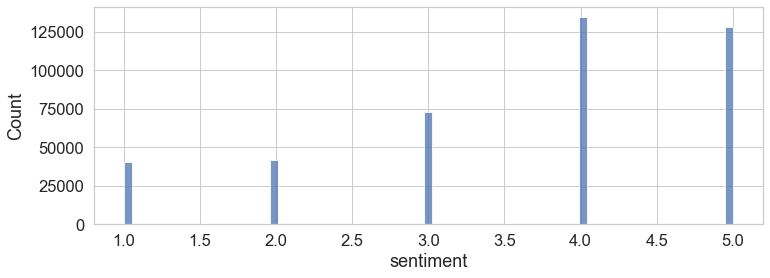

In [65]:
sns.histplot(dataset_sentiment.sentiment)

In [ ]:
#Reference code: split dataset by certain percentage (e.g.70% for training and 30% for testing) instead of cross-validation
#X_train = X[:int(X.shape[0]*0.7)]
#X_test = X[int(X.shape[0]*0.7):]
#y_train = y[:int(X.shape[0]*0.7)]
#y_test = y[int(X.shape[0]*0.7):]

In [41]:
dataset_sentiment = dataset_sentiment.drop(columns = ['date'])

In [67]:
dataset_sentiment.head(1)

,review,sentiment
25361,"Originally an old mill from 1832 located in Toronto, ON, Canada. The Distillery was re-opened to...",5


In [42]:
x = dataset_sentiment['review']
y = dataset_sentiment['sentiment']
print(len(x))
print(len(y))

417536
417536


In [43]:
#Split data by using TimeSeriesSplit
cv = TimeSeriesSplit(n_splits = 5)

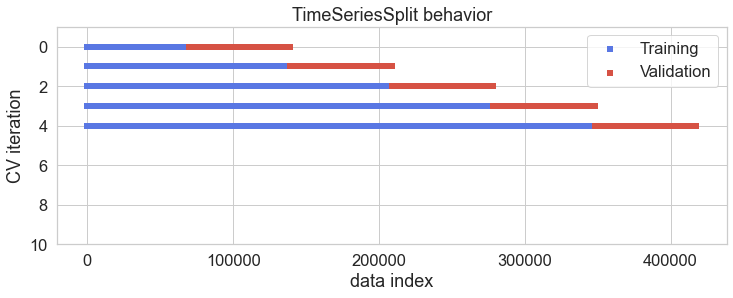

In [70]:
#Visualize the TimeSeriesSplit
#tr: train_index; tt: text_index
fig,ax = plt.subplots()
for ii, (tr,tt) in enumerate(cv.split(x,y)):
    #Plot training and test indices
    l1 = ax.scatter(tr,[ii]*len(tr), c=[plt.cm.coolwarm(.1)], marker='_',lw=6)
    l2 = ax.scatter(tt,[ii]*len(tt), c=[plt.cm.coolwarm(.9)], marker='_',lw=6)
    ax.set(ylim = [10,-1], title= 'TimeSeriesSplit behavior', xlabel='data index',ylabel='CV iteration')
    ax.legend([l1,l2],['Training','Validation'])

In [44]:
#Train and test index
for tr, tt in cv.split(x):
    print("TRAIN:", tr, "TEST:", tt) 
    X_train, X_test = x[tr], x[tt]
    y_train, y_test = y[tr], y[tt]

TRAIN: [    0     1     2 ... 69588 69589 69590] TEST: [ 69591  69592  69593 ... 139177 139178 139179]
TRAIN: [     0      1      2 ... 139177 139178 139179] TEST: [139180 139181 139182 ... 208766 208767 208768]
TRAIN: [     0      1      2 ... 208766 208767 208768] TEST: [208769 208770 208771 ... 278355 278356 278357]
TRAIN: [     0      1      2 ... 278355 278356 278357] TEST: [278358 278359 278360 ... 347944 347945 347946]
TRAIN: [     0      1      2 ... 347944 347945 347946] TEST: [347947 347948 347949 ... 417533 417534 417535]


In [45]:
#Generate X_train, X_text and y_train, y_test dataset:
for tr, tt in cv.split(x):
    X_train, X_test = x.iloc[tr], x.iloc[tt]
    y_train, y_test = y.iloc[tr], y.iloc[tt]

# Baseline

Naive Bayes with default parameters
- CountVectorizer
- Unigram
- No non-word/stop word removal
- No normalization (stemming/lemmatization)

In [ ]:
'''
CountVectorizer is used to transform a given text into a vector on the basis of the frequency (count) of each word that occurs in the entire text.
TF-IDF is a statistical measure that evaluates how relevant a word is to a document in a collection of documents. 
TF-IDF = Term Frequency (TF) * Inverse Document Frequency (IDF)
'''

In [46]:
#Prepare for training / testing:
import nltk
from nltk.corpus import stopwords

In [47]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [48]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

In [49]:
#Multinomial Classification is used for discrete counts here
from sklearn.naive_bayes import MultinomialNB

In [70]:
from yelpsent import data
from yelpsent import features
from yelpsent import metrics
from yelpsent import visualization
from yelpsent import models

In [71]:
import importlib
def reload():
  importlib.reload(data)
  importlib.reload(features)
  importlib.reload(metrics)
  importlib.reload(visualization)
  importlib.reload(models)

In [52]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Saivi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Saivi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Saivi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Saivi\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

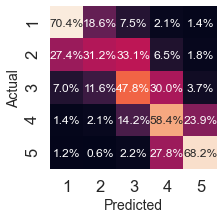

Macro F1 Scores: 
 Training: 0.5934097359161483 
 Testing: 0.5502714319418232


In [80]:
baseline, y_train_pred_baseline, y_test_pred_baseline, f1_train_baseline, f1_test_baseline = \
models.train_and_test(X_train = X_train,
                      y_train = y_train,
                      X_test = X_test,
                      y_test = y_test,
                      classifier = MultinomialNB(),
                      vectorizer = CountVectorizer())

print("Macro F1 Scores: \n Training: {0} \n Testing: {1}".format(f1_train_baseline, f1_test_baseline))

# 1 - Other Vectorizers

TfidfVectorizer

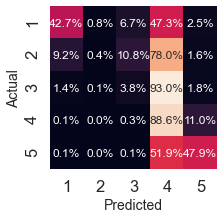

Macro F1 Scores: 
 Training: 0.466941142022224 
 Testing: 0.4246011760464458


In [107]:
tfidf, y_train_pred_tfidf, y_test_pred_tfidf, f1_train_tfidf, f1_test_tfidf = \
models.train_and_test(X_train=X_train,
                      y_train=y_train,
                      X_test=X_test,
                      y_test=y_test,
                      classifier=MultinomialNB(),
                      vectorizer=TfidfVectorizer())

print("Macro F1 Scores: \n Training: {0} \n Testing: {1}".format(f1_train_tfidf, f1_test_tfidf))

In [108]:
#get examples where: actual rating is "2", and baseline model predicted "2", and TF-IDF predicted "1"
models.get_examples(X_test, y_test, y_test_pred_baseline, y_test_pred_tfidf,4,4,5)

[("It's very good, very subtle flavours of fish, good service but overall not as good as Yasu.",
  91),
 ('Good food. Always on point. Would recommend to a friend in the area but not worth traveling for.',
  96),
 ('I really like this restaurant, I already eaten many times~ good food, good services, good environment.',
  102),
 ('Great food. Michael was great!  But cannot order alcohol from Parklet on the street. Otherwise would be 5 stars.',
  112),
 ('Lamb Biryani very good\nChicken Karachi not very authentic..\nButter chicken very good \nChicken muglai korma very good',
  116)]

In [109]:
ex = ['I really like this restaurant, I already eaten many times~ good food, good services, good environment.']

In [114]:
#How baseline model predict the rating of above two examples:
baseline.predict_proba(ex)

array([[0.01268726, 0.04772325, 0.17789759, 0.39068872, 0.37100319]])

In [115]:
#Return the term frequency of each word in two examples:
for i, v in zip(baseline.named_steps['vectorizer'].get_feature_names(),
                baseline.named_steps['vectorizer'].transform(ex).toarray().transpose()):
  if np.any(v) > 0:
    print(i, v)

already [1]
eaten [1]
environment [1]
food [1]
good [3]
like [1]
many [1]
really [1]
restaurant [1]
services [1]
this [1]
times [1]


In [116]:
#How TF-IDF model predict the rating of above two examples:
tfidf.predict_proba(ex)

array([[0.03616662, 0.048543  , 0.13660165, 0.38097378, 0.39771495]])

Binary CountVectorizer

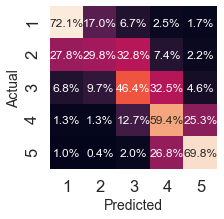

Macro F1 Scores: 
 Training: 0.6048726042577922 
 Testing: 0.5565273196429427


In [117]:
binary, y_train_pred_binary, y_test_pred_binary, f1_train_binary, f1_test_binary = \
models.train_and_test(X_train=X_train,
                      y_train=y_train,
                      X_test=X_test,
                      y_test=y_test,
                      classifier=MultinomialNB(),
                      vectorizer=CountVectorizer(binary=True))

print("Macro F1 Scores: \n Training: {0} \n Testing: {1}".format(f1_train_binary, f1_test_binary))

In [118]:
binary.predict_proba(ex)

array([[0.06563739, 0.07332392, 0.12737823, 0.27217241, 0.46148805]])

In [169]:
"""
Conclusion:
After comparing three models, binary countvertorizer has the highest F1 scores.
Binary countvertorizer will be used for our future experiments.
"""

'\nConclusion:\nAfter comparing three models, binary countvertorizer has the highest F1 scores.\nBinary countvertorizer will be used for our future experiments.\n'

# 2 - N-Grams

Unigram + Bigrams

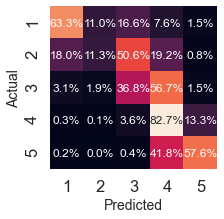

Macro F1 Scores: 
 Training: 0.8104919601136039 
 Testing: 0.538933806301886


In [120]:
bigrams, y_train_pred_bigrams, y_test_pred_bigrams, f1_train_bigrams, f1_test_bigrams = \
models.train_and_test(X_train=X_train,
                      y_train=y_train,
                      X_test=X_test,
                      y_test=y_test,
                      classifier=MultinomialNB(),
                      vectorizer=CountVectorizer(binary=True,
                                                 ngram_range=(1,2)))

print("Macro F1 Scores: \n Training: {0} \n Testing: {1}".format(f1_train_bigrams, f1_test_bigrams))

In [121]:
bigrams.predict_proba(ex)

array([[3.15584461e-06, 1.51444148e-03, 1.49970589e-02, 7.34793785e-01,
        2.48691559e-01]])

Unigram + Bigrams + Trigrams

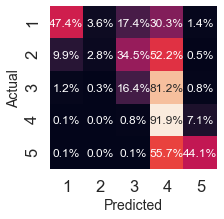

Macro F1 Scores: 
 Training: 0.9190101285618691 
 Testing: 0.4694880787258501


In [122]:
trigrams, y_train_pred_trigrams, y_test_pred_trigrams, f1_train_trigrams, f1_test_trigrams = \
models.train_and_test(X_train=X_train,
                      y_train=y_train,
                      X_test=X_test,
                      y_test=y_test,
                      classifier=MultinomialNB(),
                      vectorizer=CountVectorizer(binary=True,
                                                 ngram_range=(1,3)))

print("Macro F1 Scores: \n Training: {0} \n Testing: {1}".format(f1_train_trigrams, f1_test_trigrams))

In [123]:
trigrams.predict_proba(ex)

array([[6.02741444e-12, 4.82652077e-07, 1.51781933e-05, 9.91465394e-01,
        8.51894484e-03]])

# 2b - Remove Non-Words/Numbers

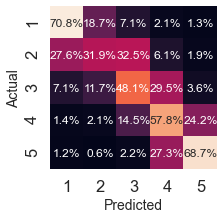

Macro F1 Scores: 
 Training: 0.5937381613867835 
 Testing: 0.5521389491697442


In [88]:
filtered, y_train_pred_filtered, y_test_pred_filtered, f1_train_filtered, f1_test_filtered = \
models.train_and_test(X_train=X_train,
                      y_train=y_train,
                      X_test=X_test,
                      y_test=y_test,
                      classifier=MultinomialNB(),
                      vectorizer=CountVectorizer(token_pattern = '[a-zA-Z0-9]+'))
print("Macro F1 Scores: \n Training: {0} \n Testing: {1}".format(f1_train_filtered, f1_test_filtered))

In [89]:
features_baseline = baseline.named_steps['vectorizer'].get_feature_names()

In [90]:
features_filtered = filtered.named_steps['vectorizer'].get_feature_names()

In [91]:
print("Baseline: {0}, Filtered: {1}".format(len(features_baseline), len(features_filtered)))

Baseline: 128292, Filtered: 123465


In [104]:
for f in features_baseline:
    if f not in features_filtered:
        print(f)
        break

00閉店と載っていても


# 3 - Remove Stopwords/Infrequent Words

In [102]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Saivi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

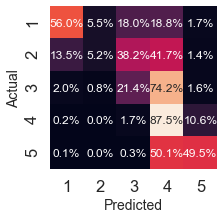

Macro F1 Scores: 
 Training: 0.8765988210444527 
 Testing: 0.49221373502506877


In [124]:
stopworded, y_train_pred_stopworded, y_test_pred_stopworded, f1_train_stopworded, f1_test_stopworded = \
models.train_and_test(X_train=X_train,
                      y_train=y_train,
                      X_test=X_test,
                      y_test=y_test,
                      classifier=MultinomialNB(),
                      vectorizer=CountVectorizer(binary=True,
                                                 ngram_range=(1,2),
                                                 stop_words=stopwords.words('english')))

print("Macro F1 Scores: \n Training: {0} \n Testing: {1}".format(f1_train_stopworded, f1_test_stopworded))

In [125]:
len(bigrams.named_steps['vectorizer'].get_feature_names())

3781534

In [126]:
len(stopworded.named_steps['vectorizer'].get_feature_names())

5465144

In [127]:
models.most_frequent_words(bigrams.named_steps['vectorizer'],
                           bigrams.named_steps['classifier'],
                           k=10)

('the', array([-5.84839187, -5.82738076, -5.65656383, -5.47872286, -5.36763789]))
('and', array([-5.88305425, -5.87342864, -5.70760519, -5.49853524, -5.37427227]))
('to', array([-5.9775457 , -5.99072218, -5.84074133, -5.70726119, -5.65231001]))
('it', array([-6.13802415, -6.05958337, -5.87508672, -5.76775618, -5.78043917]))
('of', array([-6.16155157, -6.10810839, -5.92752981, -5.78019044, -5.77188821]))
('for', array([-6.16380666, -6.10504149, -5.91625484, -5.79424578, -5.81552874]))
('was', array([-6.06950306, -6.01379349, -5.916539  , -5.87432492, -5.93156319]))
('is', array([-6.35380702, -6.25233218, -6.00582056, -5.81562092, -5.73210858]))
('in', array([-6.26975758, -6.253486  , -6.09144219, -5.93900644, -5.84189677]))
('but', array([-6.41751438, -6.14327513, -5.91402811, -5.92986572, -6.14930925]))


In [128]:
models.most_frequent_words(stopworded.named_steps['vectorizer'],
                           stopworded.named_steps['classifier'],
                           k=10)

('food', array([-6.24161995, -6.17738072, -5.99935309, -5.82675839, -5.75048772]))
('place', array([-6.58019066, -6.51521294, -6.21056474, -5.93974317, -5.86591378]))
('good', array([-6.9850117 , -6.47326973, -5.96988115, -5.80010399, -6.09785853]))
('service', array([-6.58764657, -6.54791838, -6.34419181, -6.17878953, -6.13626806]))
('like', array([-6.77580414, -6.63075846, -6.4046676 , -6.33922415, -6.55332843]))
('one', array([-6.84952222, -6.86153972, -6.68138722, -6.45558478, -6.47544757]))
('would', array([-6.89167638, -6.85506173, -6.54784838, -6.45398698, -6.7458526 ]))
('back', array([-6.87545593, -6.93307892, -6.78671463, -6.48059555, -6.46042242]))
('great', array([-7.83732153, -7.22943196, -6.68796226, -6.06021858, -5.95068119]))
('really', array([-7.34180027, -6.9144355 , -6.60111081, -6.39508825, -6.58674846]))


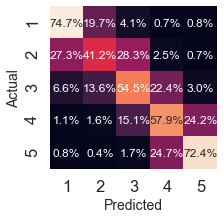

Macro F1 Scores: 
 Training: 0.7326748910058527 
 Testing: 0.5949193767137366


In [129]:
infrequented, y_train_pred_infrequented, y_test_pred_infrequented, f1_train_infrequented, f1_test_infrequented = \
models.train_and_test(X_train=X_train,
                      y_train=y_train,
                      X_test=X_test,
                      y_test=y_test,
                      classifier=MultinomialNB(),
                      vectorizer=CountVectorizer(binary=True,
                                                 ngram_range=(1,2),
                                                 min_df=6))

print("Macro F1 Scores: \n Training: {0} \n Testing: {1}".format(f1_train_infrequented, f1_test_infrequented))

In [130]:
len(bigrams.named_steps['vectorizer'].get_feature_names())

3781534

In [131]:
len(infrequented.named_steps['vectorizer'].get_feature_names())

507869

# 4 - Normalization

Stemming

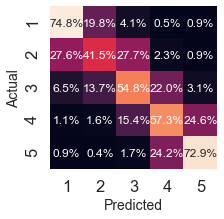

Macro F1 Scores: 
 Training: 0.719482969661493 
 Testing: 0.5954833623323391


In [53]:
stemmed, y_train_pred_stemmed, y_test_pred_stemmed, f1_train_stemmed, f1_test_stemmed = \
models.train_and_test(X_train=X_train,
                      y_train=y_train,
                      X_test=X_test,
                      y_test=y_test,
                      classifier=MultinomialNB(),
                      vectorizer=features.YelpSentCountVectorizer(ngram_range=(1,2),
                                                                  remove_nonwords=False,
                                                                  remove_stopwords=False,
                                                                  stem=True,
                                                                  lemmatize=False,
                                                                  min_df=6,
                                                                  binary=True))

print("Macro F1 Scores: \n Training: {0} \n Testing: {1}".format(f1_train_stemmed, f1_test_stemmed))

In [54]:
example_words = ['what a trouble',
                 'this is very troubling',
                 'i am troubled']

In [55]:
stem_vec = features.YelpSentCountVectorizer(stem=True)
lemma_vec = features.YelpSentCountVectorizer(lemmatize=True)

In [56]:
example_stemmed = stem_vec.fit_transform(example_words)
example_lemmed = lemma_vec.fit_transform(example_words)

In [57]:
stem_vec.get_feature_names()

['a', 'am', 'i', 'is', 'thi', 'troubl', 'veri', 'what']

In [58]:
example_stemmed.toarray()

array([[1, 0, 0, 0, 0, 1, 0, 1],
       [0, 0, 0, 1, 1, 1, 1, 0],
       [0, 1, 1, 0, 0, 1, 0, 0]], dtype=int64)

In [59]:
features_stemmed = stem_vec.get_feature_names()

words_stemmed = []
for sent in example_stemmed.toarray():
  words = []
  for i, w in enumerate(sent):
    if w > 0:
      words.append(features_stemmed[i])
  words_stemmed.append(' '.join(words))

In [60]:
words_stemmed

['a troubl what', 'is thi troubl veri', 'am i troubl']

In [61]:
features_lemmed = lemma_vec.get_feature_names()

words_lemmed = []
for sent in example_lemmed.toarray():
  words = []
  for i, w in enumerate(sent):
    if w > 0:
      words.append(features_lemmed[i])
  words_lemmed.append(' '.join(words))

In [62]:
words_lemmed

['a trouble what', 'be this troubling very', 'be i trouble']

In [68]:
len(stemmed.named_steps['vectorizer'].get_feature_names())

446227

Lemmatization

In [63]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Saivi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [65]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Saivi\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

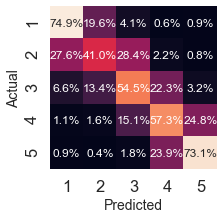

Macro F1 Scores: 
 Training: 0.7181577009090642 
 Testing: 0.5949647405690791


In [66]:
lemmatized, y_train_pred_lemmatized, y_test_pred_lemmatized, f1_train_lemmatized, f1_test_lemmatized = \
models.train_and_test(X_train=X_train,
                      y_train=y_train,
                      X_test=X_test,
                      y_test=y_test,
                      classifier=MultinomialNB(),
                      vectorizer=features.YelpSentCountVectorizer(ngram_range=(1,2),
                                                                  remove_nonwords=False,
                                                                  remove_stopwords=False,
                                                                  stem=False,
                                                                  lemmatize=True,
                                                                  min_df=6,
                                                                  binary=True))

print("Macro F1 Scores: \n Training: {0} \n Testing: {1}".format(f1_train_lemmatized, f1_test_lemmatized))

In [ ]:
final_vectorizer = lemmatized.named_steps['vectorizer']

In [67]:
len(lemmatized.named_steps['vectorizer'].get_feature_names())

439416

# Conclusion

We should
- CountVectorizer, binarized
- Unigram + Bigram
- Min DF of 6
- Stemming

Next step: following four machine learning models will be used in the experiment and compared with the baseline model
- Multinomial Logistic Regression
- Support Vector Machine
- k-Nearest-Neighbors (kNN)
- RandomForest (RF)

In [76]:
final_vectorizer = stemmed.named_steps['vectorizer']

In [77]:
final_X_train_dtm = final_vectorizer.transform(X_train)
final_X_test_dtm = final_vectorizer.transform(X_test)

# Multinomial Logistic Regression

In [73]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [80]:
# # Grid-search for c
params = dict(C = np.logspace(-3, 0, 4),
              penalty = ['l1', 'l2'])

gscv = GridSearchCV(LogisticRegression(max_iter=500,
                   multi_class='multinomial'),
                    params,
                    scoring='f1_macro',
                    cv=cv,
                    verbose=1,
                    n_jobs=-1)

In [ ]:
gscv.fit(final_X_train_dtm, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [ ]:
print(gscv.best_params_)

In [ ]:
# # Selected model:
# model = LogisticRegression(C=0.01,
#                            penalty='l2',
#                            max_iter=1000,
#                            random_state=647,
#                            n_jobs=-1)

In [ ]:
# %time model.fit(X_train_dtm, y_train)

In [ ]:
#y_train_pred, y_test_pred, f1_train, f1_test =\
models.evaluate_pipeline(X_train = X_train_dtm,
                         y_train = y_train,
                         X_test = X_test_dtm,
                         y_test = y_test,
                         pipeline = model)

print("Macro F1 Scores: \n Training: {0:.3f} \n Testing: {1:.3f}\n\n".format(f1_train, f1_test))

# SVM

In [ ]:
from sklearn.svm import LinearSVC

In [ ]:
params

In [ ]:
# Grid-search for C
params = {'C' : np.logspace(-5, -2, 6)}

gscv = GridSearchCV(LinearSVC(max_iter=1000),
                    params,
                    scoring='f1_macro',
                    cv=cv,
                    verbose=1,
                    n_jobs=-1)

In [ ]:
gscv.fit(X_train_dtm, y_train)

In [ ]:
print(gscv.best_params_)

In [ ]:
#model = LinearSVC(max_iter=1000,
                  C=0.0025118864315095794,
                  random_state=647)

In [ ]:
%time model.fit(X_train_dtm, y_train)

In [ ]:
#y_train_pred, y_test_pred, f1_train, f1_test =\
models.evaluate_pipeline(X_train = X_train_dtm,
                         y_train = y_train,
                         X_test = X_test_dtm,
                         y_test = y_test,
                         pipeline = model)

print("Macro F1 Scores: \n Training: {0:.3f} \n Testing: {1:.3f}\n\n".format(f1_train, f1_test))

# KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor